In [1]:
import warnings
import yfinance as yf
import numpy as np
from numpy import where
from pandas import concat, DataFrame, Series
import matplotlib.pyplot as plt
plt.style.use('dark_background')
warnings.filterwarnings("ignore")
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
def corrigindo_sinal(df):
  try:
    if df[0] == 'erro':
      pass
  except:
    df[0] = 0
  try:
    if df[1] == 'erro':
      pass
  except:
    df[1] = 0
  return df

def acima_media(df):
  df['media'] = df['retorno_modelo'].rolling(120).mean()
  df.dropna(inplace=True)
  lista = None
  lista = []
  contador:int = 0
  for retorno_modelo, media in df[['retorno_modelo', 'media']].values:
    if retorno_modelo > media:
      contador += 1
    else:
      if contador == 0 or contador == 1:
        contador = 0
      else:
        lista.append(contador)
        contador = 0
  if contador == len(df):
    return len(df)
  else:
    s = None
    s = Series(lista)
    return s.max()

def LRDCUNHASS(ativo:str, normal:bool=None, otimizacao:bool=None, ot:int=1, qualidade:bool=None, grafico:bool=None):
  d0 = None # Na modelagem a data é diferente
  d0 = yf.download(ativo, start='2012-05-15', end='2022-05-15', progress=False)[['Adj Close']].rename(columns={'Adj Close': 'adj_close'})
  d1 = None
  d1 = d0.copy()
  d1['retorno'] = d1.adj_close.pct_change(1)
  d1['alvo'] = d1.retorno.shift(-1)
  d1['centavos'] = d1.adj_close - d1.adj_close.shift(1)
  d1['alvo_bin'] = where(d1.alvo > 0, 1, 0)
  if normal is True or grafico is True:
    try:
      d1['feature_template'] = feature_template(d1.retorno, t=5)
    except ValueError:
      print('Remover "chave"!')
  elif otimizacao is True:
    d1['feature_template'] = feature_template(d1.retorno, ot=ot)[0]
  if qualidade is True:
    d1['feature_template'] = feature_template(d1.retorno, ot=ot)[0]
  treino = d1[d1.index[0]: d1.index[round(d1.shape[0] * 0.50)]].dropna()
  teste = d1[d1.index[round(d1.shape[0] * 0.50)]: d1.index[-1]]
  try:
    arvo = DecisionTreeClassifier(criterion='gini', max_depth=3)
    arvo.fit(treino[treino.columns[5:].values], treino['alvo_bin'])
    preo = arvo.predict(treino[treino.columns[5:].values])
    pree = arvo.predict(teste[teste.columns[5:].values])
    treino['previsto'] = preo
    teste['previsto'] = pree
    d2 = concat([treino, teste], axis=0)
    d2['serie_retorno'] = where(d2['previsto'] == 1, d2['centavos'], '0')
    d2['serie_retorno'] = where(d2['previsto'] == 0, -1 * d2['centavos'], d2['serie_retorno']).astype(float)
    d2['retorno_modelo'] = d2['serie_retorno'].cumsum() * 100
    acuracia_treino = metrics.accuracy_score(treino.alvo_bin, preo) * 100
    acuracia_teste = metrics.accuracy_score(teste.alvo_bin, pree) * 100
    percentual_positivo = (d2['serie_retorno'] > 0).value_counts()[True] / len(d2)
    percentual_positivo_teste = (d2['serie_retorno'][teste['previsto'].index[0]: teste['previsto'].index[-1]] > 0).value_counts()[True] / len(teste)
    quantidade_sinal_treino = corrigindo_sinal(DataFrame(preo).value_counts())
    quantidade_sinal_teste = corrigindo_sinal(DataFrame(pree).value_counts())
    dados_perdidos = len(d0) - len(d2)
    retornos_acima_media = acima_media(d2)
    ls = None
    ls = [acuracia_treino, acuracia_teste, percentual_positivo, percentual_positivo_teste, quantidade_sinal_treino, quantidade_sinal_teste, dados_perdidos, retornos_acima_media]
    if normal is True:
      print(f'> [ {acima_media(d2)} ]   to: [ {ls[0]:.2f} ] [ V {ls[4][0]} ] [ C {ls[4][1]} ]   te: [ {ls[1]:.2f} ] [ {ls[3]:.3f} ] [ V {ls[5][0]} ] [ C {ls[5][1]} ]   tt: [ {ls[2]:.3f} ] [ {ls[6]} ]')
      return None
    if grafico is True:
      plt.figure(figsize=(10, 5))
      d2.retorno.cumsum().plot(color='w', linewidth=.4)
      d2['retorno_modelo'].plot(secondary_y=True, color='purple')
      d2['retorno_modelo'].rolling(120).mean().plot(secondary_y=True, color='red', linewidth=.7)
      return None
    if otimizacao is True or qualidade is True:
      return ls
  except:
    if normal is True:
      print('ERRO!')
      return None
    if otimizacao is True:
      return [0, 0, 0, 0, 0, 0, 0]
    if qualidade is True:
      print('ERRO! QUALIDADE')
      return None

In [3]:
def FERRAMENTAS(ativo:str, periodo:str='all', Q:int=20, A1=56, A2=51, P1=0.50, P2=0.50):
  d1 = yf.download(ativo, start='2012-05-15', end='2022-05-15', progress=False)[['Adj Close']].rename(columns={'Adj Close': 'adj_close'})
  d1['retorno'] = d1.adj_close.pct_change(1)
  feature = feature_template(d1.retorno, t=5)
  if not(str(type(feature))[1:-1][7:-1] == 'tuple'):
    if periodo == 'all':
      periodo = len(d1)
    else:
      periodo = int(periodo)
    plt.figure(figsize=(25,5))
    plt.subplot(1, 2, 1)
    feature.tail(periodo).plot(color='purple')
    plt.xticks(fontsize=8)
    plt.xlabel(None)
    plt.subplot(1, 2, 2)
    plt.scatter(feature, d1['retorno'], color='w', alpha=.5, linewidth=3)
    plt.xlabel(None)
    print(f'Normalidade [ {feature.max() - feature.min()} ]\n')
    return None
  elif str(type(feature))[1:-1][7:-1] == 'tuple' and feature[1] == 'qr':
    def dados() -> list:
      l1 = None
      l2 = None
      l3 = None
      l4 = None
      l1, l2, l3, l4 = [], [], [], []
      for i in range(Q):
        ls = None
        ls = LRDCUNHASS(ativo=ativo, qualidade=True)
        l1.append(ls[0])
        l2.append(ls[1])
        l3.append(ls[2])
        l4.append(ls[3])
      return l1, l2, l3, l4
    def padrao(ls):
      erro:bool = False
      for i in range(len(ls)):
        if not(i):
          pass
        else:
          x = None
          y = None
          x = ls[i-1]
          y = ls[i]
          if x == y:
            pass
          else:
            erro = True
            break
      if erro is True:
          return 'NOT!'
      elif erro is False:
          return 'OK!'
    dd = dados()
    print(padrao(dd[0]), padrao(dd[1]), padrao(dd[2]), padrao(dd[3]), '\n')
  elif str(type(feature))[1:-1][7:-1] == 'tuple' and feature[1] == 'ot':
    try:
        for i in range(2, 26):
            ls = None
            ls = LRDCUNHASS(ativo=ativo, otimizacao=True, ot=i)
            if ls[0] < A1 and ls[1] >= A2 and ls[2] > P1 and ls[3] > P2:
                print(f'[ P = {i} ]   > [ {ls[7]} ]   to: [ {ls[0]:.2f} ] [ V {ls[4][0]} ] [ C {ls[4][1]} ]   te: [ {ls[1]:.2f} ] [ {ls[3]:.3f} ] [ V {ls[5][0]} ] [ C {ls[5][1]} ]   tt: [ {ls[2]:.3f} ] [ {ls[6]} ]')
        print('\nCompleto!')
        return None
    except KeyboardInterrupt:
        print('Interrompido!\n')
        return None

In [ ]:
def feature1(m, t=5):
    W = lambda x, t=5: x.rolling(t).sum()
    R = lambda x, t=5: x.rolling(t).max()
    E = lambda x, t=5: x.rolling(t).mean()
    A = lambda x: R(x + x.shift(1)) / E(x, 5)
    Z = lambda x: W(A(x, 5) * x.diff(), 6) - W(A(x, 9) * x.diff(), 2).shift(2)
    return Z(m)

In [ ]:
def feature2(m, t=5):
    W = lambda x, t=5: x.rolling(t).sum()
    R = lambda x, t=5: x.rolling(t).max()
    E = lambda x, t=5: x.rolling(t).mean()
    A = lambda x, t=5: R(x + x.shift(1)) / E(x, t)
    Z = lambda x: W(A(x, 5) * x.diff(), 6) - W(A(x, 9) * x.diff(), 2).shift(2)
    X = lambda x: Z(x).diff() + Z(E(x, 3)).diff()
    return X(m)

In [ ]:
def feature3(m, t=5):
    W = lambda x, t=5: x.rolling(t).sum()
    R = lambda x, t=5: x.rolling(t).max()
    E = lambda x, t=5: x.rolling(t).mean()
    A = lambda x, t=5: R(x + x.shift(1)) / E(x, t)
    Z = lambda x: W(A(x, 5) * x.diff(), 6) - W(A(x, 9) * x.diff(), 2).shift(2)
    X = lambda x: Z(x).diff() + Z(E(x, 3)).diff()
    C = lambda x: W(X(x) * x, 18)
    return C(m)

In [ ]:
def feature3(m, t=5):
    W = lambda x, t=5: x.rolling(t).sum()
    R = lambda x, t=5: x.rolling(t).max()
    E = lambda x, t=5: x.rolling(t).mean()
    A = lambda x, t=5: R(x + x.shift(1)) / E(x, t)
    Z = lambda x: W(A(x, 5) * x.diff(), 6) - W(A(x, 9) * x.diff(), 2).shift(2)
    X = lambda x: Z(x).diff() + Z(E(x, 3)).diff()
    C = lambda x: W(X(x) * x, 18)
    V = lambda x: E(E(C(x).diff() * m, 23) * W(m, 5), 5)
    return C(m)

mc = Q(m.diff() + m.shift(1).diff(), 10) - m.diff()

In [ ]:
def feature_template(m, t=5, ot=1):
    pi = 3.14159265359
    ri = 2.83132302928

    N1 = lambda x, t=5: x.rolling(t).max() - x
    N2 = lambda x, t=5: x.rolling(t).min() - x

    Q = lambda x, t=5: x.rolling(t).std()
    W = lambda x, t=5: x.rolling(t).sum()
    E = lambda x, t=5: x.rolling(t).mean()
    R = lambda x, t=5: x.rolling(t).max()
    T = lambda x, t=5: x.rolling(t).min()
    Y = lambda x, t=5: x.diff() + x.diff().shift(t)
    U = lambda x, t=1: x - x.shift(t)

    A = lambda x, t=5: R(x + x.shift(1)) / E(x, t)
    S = lambda x, t=5: Q(x - x.shift(1), t)
    D = lambda x, t=5: W(x - E(x, t), t)
    F = lambda x, t=5: R(x.diff() * x.shift(1).diff(), t)

    Z = lambda x: W(A(x, 5) * x.diff(), 6) - W(A(x, 9) * x.diff(), 2).shift(2)
    X = lambda x: Z(x).diff() + Z(E(x, 3)).diff()
    C = lambda x: W(X(x) * x, 18)
    V = lambda x: E(E(C(x).diff() * m, 23) * W(m, 5), 5)
    B = lambda x: V(x) - E(V(x), t)

    return B(m), 'ot'

FERRAMENTAS('goau4.sa', '300', Q=20, A1=60, A2=40, P1=0.480, P2=0.480)
LRDCUNHASS('goau4.sa', normal=True)


Completo!
Remover "chave"!
ERRO!


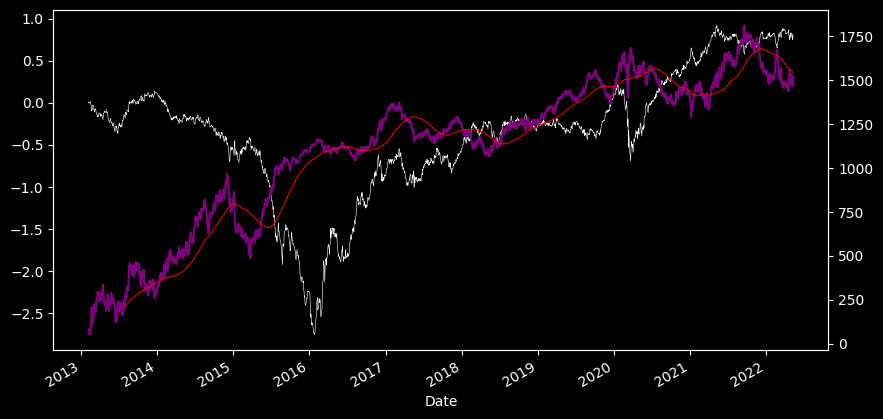

In [ ]:
LRDCUNHASS('goau4.sa', grafico=True)

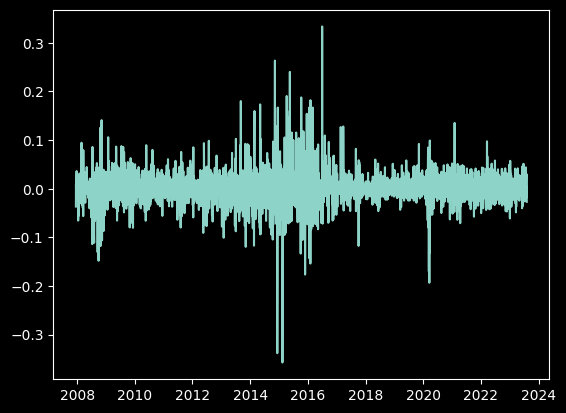

In [ ]:
from yfinance import download
import matplotlib.pyplot as plt
d1 = download(tickers='enev3.sa', period='max', progress=False)
retorno = d1['Adj Close'].pct_change()
plt.plot(retorno)